# How to train a VAE with AUTOENCODIX

Here, we are using the example data from TCGA for Stomach Adenocarinoma.

The Setup_InputFormat [notebook](Setup_InputFormat.ipynb) we ran earlier is the prerequisite for this notebook. 

## Make sure you are using the correct kernel 
You probably have already selected **autoencodix-ga-kernel** (visible in the top right corner of this notebook) as instructed in `install-kernel-script.ipynb`, if not:

Select the **autoencodix-ga-kernel** in the Top Menu -> Kernel -> Change Kernel"

If it is not listed, reload the browser and try again.

## Test Notebook Setup
Firstly, we need to ensure we are working in the correct directory. The next cell ensures this, all other cells will assume you are in `/data/horse/ws/<YOURUSERNAME>-AE-ws/autoencodix/Tutorials` and will change directories based on this location if needed.

In [4]:
import os
path = os.path.expandvars("$HOME/horse/$USER-AE-ws/autoencodix/Tutorials")
os.chdir(path)

cur_dir = os.getcwd()
print(f"Current working directory: {cur_dir}")

Current working directory: /data/horse/ws/majo158f-AE-ws/autoencodix/Tutorials


## (Step 1) Check your input data
Input data must have shape samples x features and should be in `data/raw`

In [ ]:
from pathlib import Path
raw_data_dir = Path(os.path.expandvars("$HOME/horse/$USER-AE-ws/autoencodix/data/raw/"))
parquet_files = list(raw_data_dir.glob("combined*.parquet"))
print("Parquet files:")
for file in parquet_files:
    print(file.name)

Parquet files:
combined_rnaseq_formatted.parquet
combined_clin_formatted.parquet
combined_meth_formatted.parquet


## (Step 2) Create your yaml-config to training and pipeline specification
A full documentation of config parameters can be found in `ConfigParams.md`

In [10]:
## We will use Python for config defintion, but you can write your own yaml-config with an editor
import yaml
cfg = dict()
# DATA DEFINITIONS ------------------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DATA_TYPE'] = dict()
# RNAseq
cfg['DATA_TYPE']['RNA'] = dict()
cfg['DATA_TYPE']['RNA']['SCALING'] = "Standard"	# We scale features by the standard scaler
cfg['DATA_TYPE']['RNA']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['RNA']['FILTERING'] = "Var"	# We filter for feature with highest variance
cfg['DATA_TYPE']['RNA']['FILE_RAW'] = "combined_rnaseq_formatted.parquet"

# METH
cfg['DATA_TYPE']['METH'] = dict()
cfg['DATA_TYPE']['METH']['SCALING'] = "Standard"
cfg['DATA_TYPE']['METH']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['METH']['FILTERING'] = "Var"
cfg['DATA_TYPE']['METH']['FILE_RAW'] = "combined_meth_formatted.parquet"

# Clinical Parameters for plotting
cfg['DATA_TYPE']['ANNO'] = dict()
cfg['DATA_TYPE']['ANNO']['TYPE'] = "ANNOTATION"
cfg['DATA_TYPE']['ANNO']['FILE_RAW'] = "combined_clin_formatted.parquet"

## Model and Training --------------------------------------------------------
# ----------------------------------------------------------------------------
# Reproducibility
cfg['FIX_RANDOMNESS'] = "all"
cfg['GLOBAL_SEED'] = 42
# Model
cfg['MODEL_TYPE'] = "varix" # Train a basic VAE
cfg['TRAIN_TYPE'] = "train" # simple training, no tuning
cfg['RECONSTR_LOSS'] = "MSE"	# loss function for reconstruction
cfg['VAE_LOSS'] = "KL"		# loss function distribution distance
cfg['BETA'] = 0.5			# weighting of VAE loss

cfg['K_FILTER'] = 1000		# Input features per data modality
cfg["LATENT_DIM_FIXED"] = 6	# Latent space dimension
# Training
cfg['EPOCHS'] = 500
cfg['LR_FIXED'] = 0.0005	# Learning rate
cfg['BATCH_SIZE'] = 128
cfg['DROP_P'] = 0.1			# We have a small number of samples and should be aggressive with drop out to avoid overfitting
# Prediction
cfg['PREDICT_SPLIT'] = "all"	# Embedding of all samples should be calculated in prediction
# EVALUATION and VISUALIZATION ------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DIM_RED_METH'] = "UMAP"	# For 2D visualization when LATENT_DIM_FIXED>2
cfg['CLINIC_PARAM'] = [			# Parameters to colorize plots and perform embedding evaluation
				"CANCER_TYPE",
				"CANCER_TYPE_ACRONYM",
				"TMB_NONSYNONYMOUS",
				"AGE",
				"SEX",
				"GRADE",
				"OS_STATUS"
			]
cfg['ML_TYPE'] = "Auto-detect"	# Is CLINIC_PARAM prediction either regression or classification?
cfg['ML_ALG'] = [				# ML algorithms for embedding evaluation
	'Linear',
	'RF'
	]
cfg['ML_SPLIT'] = "use-split"	# Test ML performance on train, test, valid split
cfg['ML_TASKS'] = [				# Compare embeddings to other dimension reduction methods
	'Latent',
	'UMAP',
	'PCA',
	'RandomFeature'
]


## save config
with open("../"+"TCGA-Example_config.yaml", 'w') as file:
	yaml.dump(cfg, file)

## (Step 3) Start pipeline
you can run the pipeline all at once with `make ml_task`, which will do the following steps:
- `make data_only` to preprocess the input
- `make model_only` to train the autoencoder
- `make prediction_only` calculate latent space embedding and reconstruction of specified samples
- `make visualize_only` create loss and latent space visualizations
- `make ml_task_only` evaluate latent space and embedding performance

In the tutorial we will make it step-by-step

### (Step 3A) preprocess data

In [12]:
import os

# Make sure to start from project root folder
project_path = os.path.expandvars("$HOME/horse/$USER-AE-ws/autoencodix")
os.chdir(project_path)
print(f"Current directory: {os.getcwd()}")

# Setting CUBLAS for reproducibility if you train on GPU
%env CUBLAS_WORKSPACE_CONFIG=:16:8
# Activate venv
!source venv-gallia/bin/activate
# Start preprocessing
!make data RUN_ID=TCGA-Example

Current directory: /data/horse/ws/majo158f-AE-ws/autoencodix
env: CUBLAS_WORKSPACE_CONFIG=:16:8
/bin/bash: line 1: venv-gallia/bin/activate: No such file or directory
Detected platform: Linux
Setting up directories and configuration for RUN_ID: TCGA-Example
✓ Configuration complete
python3 src/data/make_dataset.py TCGA-Example
2025-09-03 16:37:54,026 - src.utils.utils_basic - INFO - Unify sample ID list from data files
2025-09-03 16:37:57,275 - src.utils.utils_basic - INFO - Save sample split.
2025-09-03 16:37:57,305 - src.utils.utils_basic - INFO - Unified sample ID list has length 3529
2025-09-03 16:37:57,305 - src.utils.utils_basic - INFO - Make data set ANNO
2025-09-03 16:37:57,317 - src.utils.utils_basic - INFO - Save ANNOTATION without preprocessing
2025-09-03 16:37:57,336 - src.utils.utils_basic - INFO - Make data set METH
2025-09-03 16:37:58,082 - src.utils.utils_basic - INFO - Select for samples and drop features with NA
2025-09-03 16:37:58,259 - src.utils.utils_basic - INFO -

### (Step 3B) train the variational autoencoder (Varix)
this may take some time depending on your machine and GPU (around 2min for a RTX 2070)

In [13]:
# Setting CUBLAS for reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:16:8

!make model_only RUN_ID=TCGA-Example

env: CUBLAS_WORKSPACE_CONFIG=:16:8
Detected platform: Linux
Setting up directories and configuration for RUN_ID: TCGA-Example
✓ Configuration complete
python3 src/models/train.py TCGA-Example
2025-09-03 16:40:39,634 - src.utils.utils_basic - INFO - DATA SIZE:torch.Size([2470, 2000])
2025-09-03 16:40:40,517 - src.utils.utils_basic - INFO - total epochs:500
2025-09-03 16:40:59,377 - src.utils.utils_basic - INFO - Train Set: Epoch: 0, Loss: 2061.01, r_Loss: 2059.70, vae_loss: 1.31, r2: -0.07
2025-09-03 16:40:59,382 - src.utils.utils_basic - INFO -  Valid Set: Epoch: 0 Loss: 11657.23, r2: -0.00
2025-09-03 16:41:03,296 - src.utils.utils_basic - INFO - Train Set: Epoch: 50, Loss: 1101.57, r_Loss: 1101.22, vae_loss: 0.35, r2: 0.42
2025-09-03 16:41:03,299 - src.utils.utils_basic - INFO -  Valid Set: Epoch: 50 Loss: 1508.53, r2: 0.43
2025-09-03 16:41:07,212 - src.utils.utils_basic - INFO - Train Set: Epoch: 100, Loss: 1063.29, r_Loss: 1058.83, vae_loss: 4.47, r2: 0.44
2025-09-03 16:41:07,215 - 

### (Step 3C) calculate latent space embeddings of all samples
for visualization and evaluation latant space for all samples are calculated

In [14]:
!make prediction_only RUN_ID=TCGA-Example

Detected platform: Linux
Setting up directories and configuration for RUN_ID: TCGA-Example
✓ Configuration complete
python3 src/models/predict.py TCGA-Example
2025-09-03 16:41:56,141 - src.utils.utils_basic - INFO - ['METH', 'RNA']
2025-09-03 16:41:59,042 - src.utils.utils_basic - INFO - DATA SIZE:torch.Size([3529, 2000])
2025-09-03 16:41:59,079 - src.utils.utils_basic - INFO - Model structure:
2025-09-03 16:41:59,080 - src.utils.utils_basic - INFO - Varix(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
  )
  (mu): Linear(in_features=500, out_features=6, bias=True)
  (logvar): Linear(in_features=500, out_features=6, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

### (Step 3D) Visualize results
plots for loss and latent space are generated

In [15]:
!make visualize_only RUN_ID=TCGA-Example

Detected platform: Linux
Setting up directories and configuration for RUN_ID: TCGA-Example
✓ Configuration complete
python3 src/visualization/visualize.py TCGA-Example
2025-09-03 16:42:08,815 - src.utils.utils_basic - INFO - Plotting loss per type over epochs.
2025-09-03 16:42:08,817 - src.utils.utils_basic - INFO - Plotting loss for reports/TCGA-Example/losses_METH_RNA_varix.parquet
2025-09-03 16:42:12,599 - src.utils.utils_basic - INFO - Performing UMAP for 2D latent space visualization.
2025-09-03 16:42:26,298 - src.utils.utils_basic - INFO - Plot UMAP with SPLIT as labels.
2025-09-03 16:42:27,144 - src.utils.utils_basic - INFO - Plot UMAP with CANCER_TYPE as labels.
2025-09-03 16:42:27,461 - src.utils.utils_basic - INFO - Plot UMAP with CANCER_TYPE_ACRONYM as labels.
2025-09-03 16:42:27,959 - src.utils.utils_basic - INFO - Plot UMAP with TMB_NONSYNONYMOUS as labels.
2025-09-03 16:42:27,960 - src.utils.utils_basic - INFO - The provided label column is numeric and converted to catego

### Visualizations
For evaluation of model training and autoencoder performance we generate multiple visualizations:  
- Loss curves
- Ridgeline (density) plots of each latent dimension grouped by annotation parameters
- 2D latent space representations colored by annotation parameters

Optionally to those standard plots, you can activate via config parameters additional plots:
- Heatmap of model weights before and after training (config: `PLOT_WEIGHTS`)
- 2D representation of direct input embedding by UMAP, PCA or t-SNE for comparison (config: `PLOT_INPUT2D`)
- Clustering and visualization of 2D latent space representation (config: `PLOT_CLUSTLATENT`)
- Plot 2D latent representation at each checkpoint during training (config: `CHECKPT_PLOT`)

In the following we show the standard visualizations.

(1) Loss curves

Loss curves on log-scale


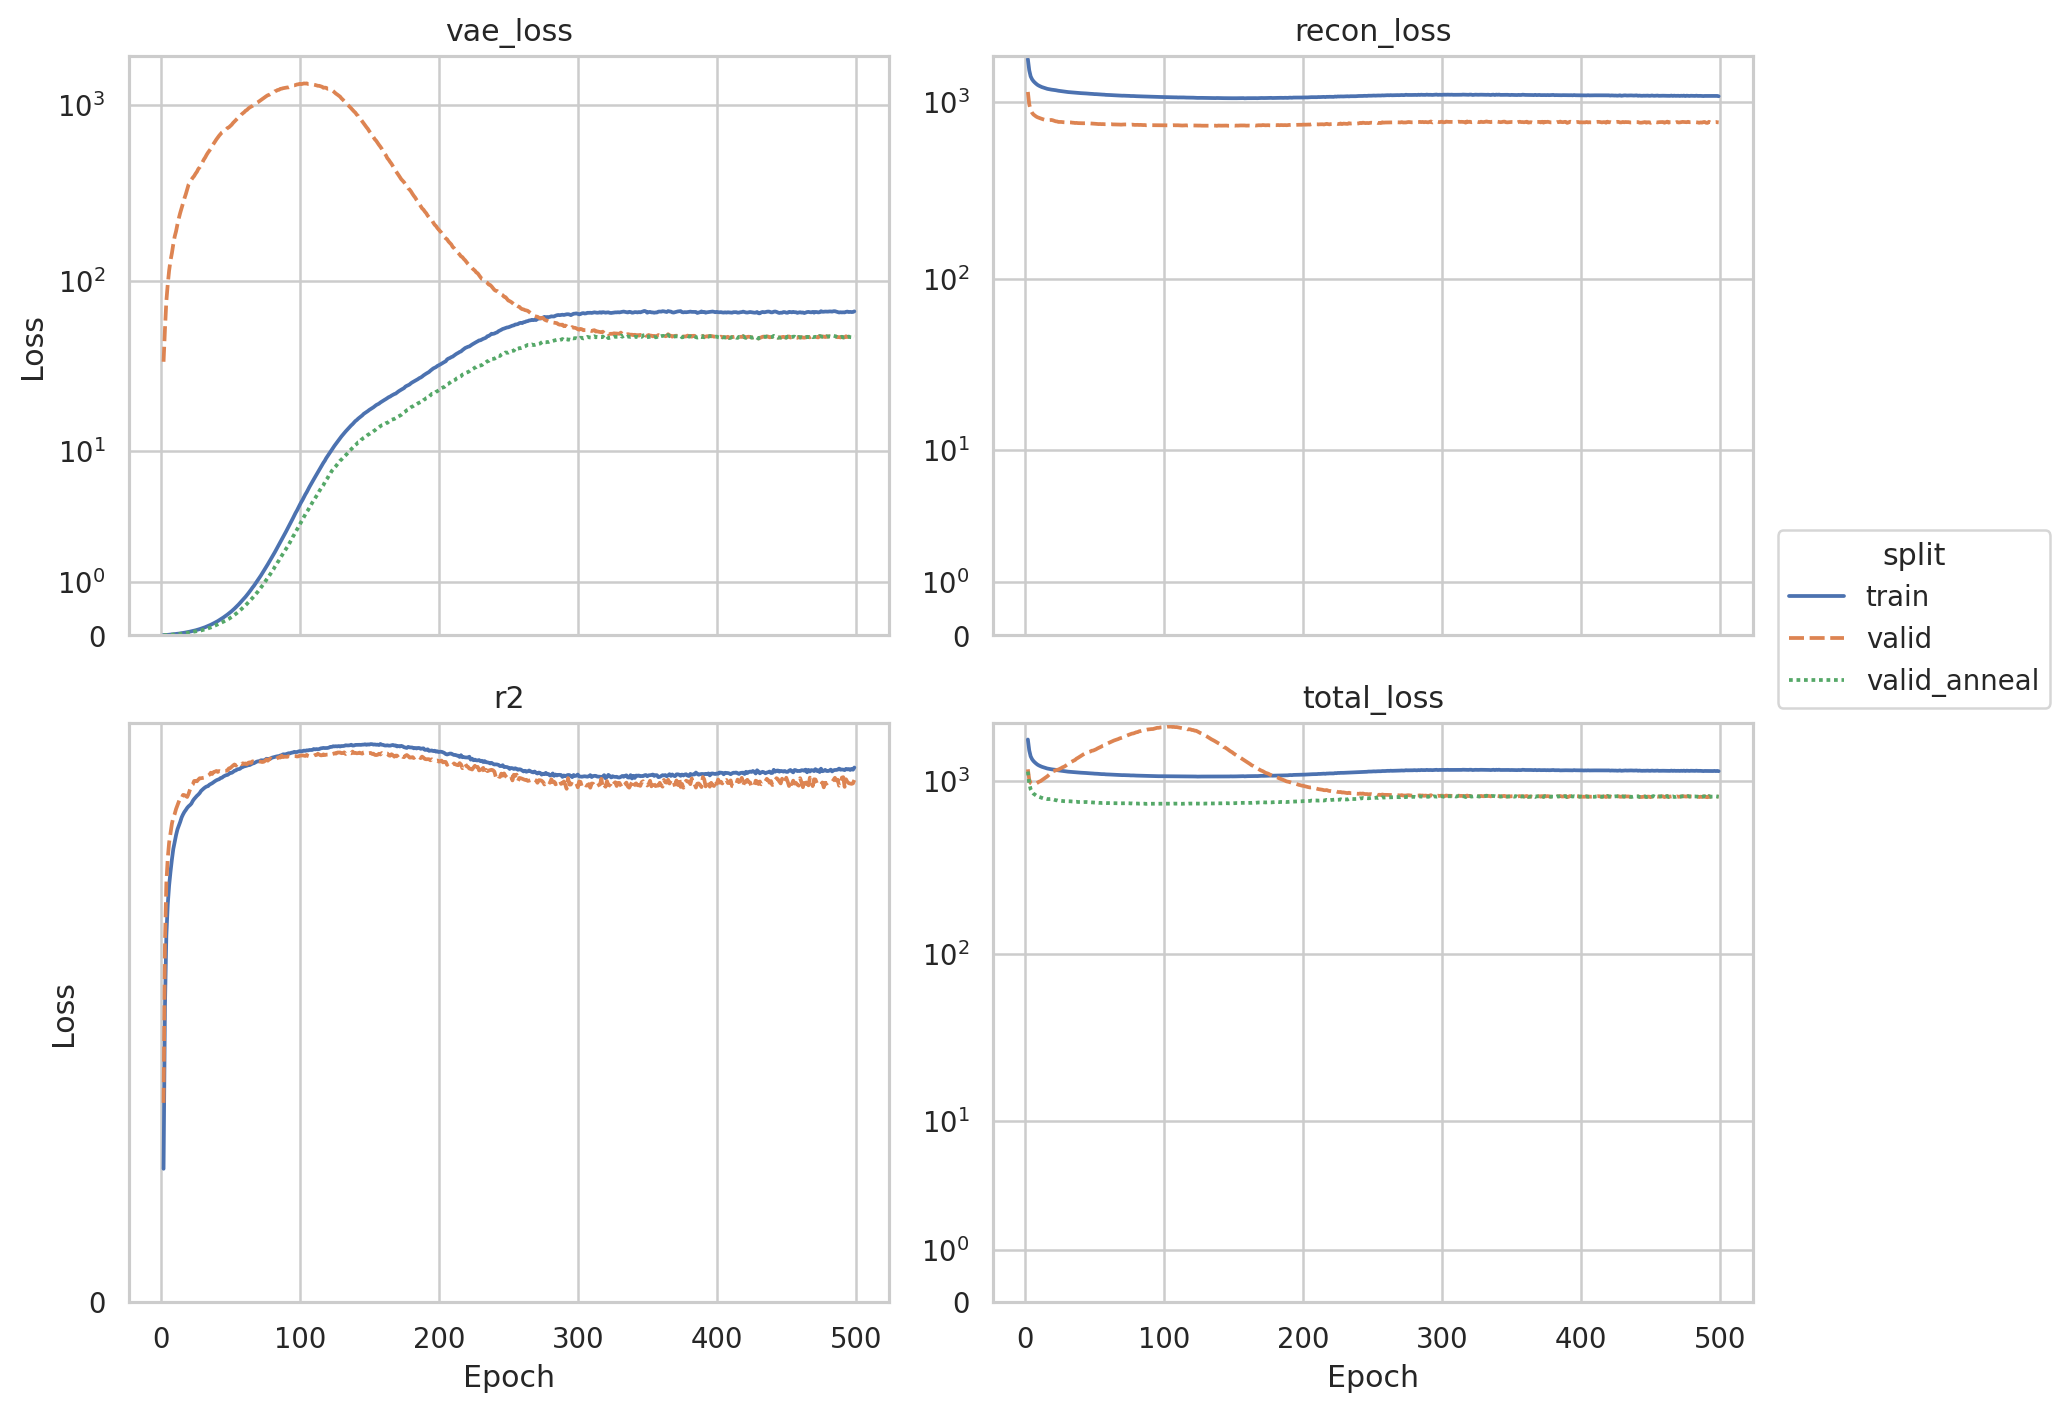

Relative contribution of loss terms to total loss


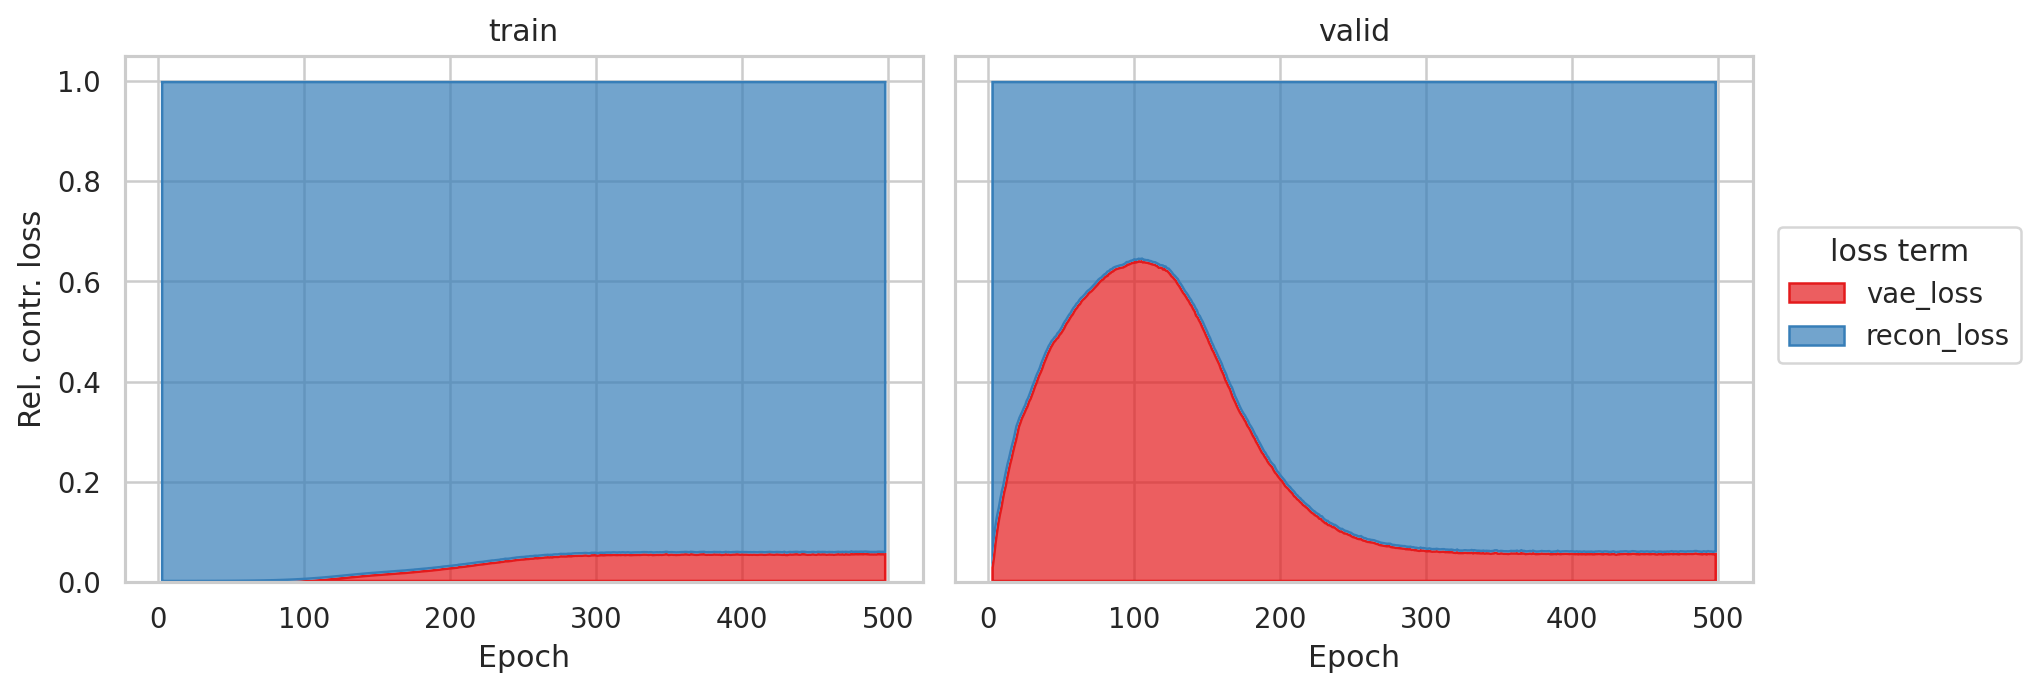

In [16]:
from IPython.display import Image
from IPython.display import display

loss_absolute = Image(filename='reports/TCGA-Example/figures/loss_plot_absolute.png', width=800)
loss_relative = Image(filename='reports/TCGA-Example/figures/loss_plot_relative.png', width=800)

print("Loss curves on log-scale")
display(loss_absolute)
print("Relative contribution of loss terms to total loss")
display(loss_relative)


(2) Ridgeline (density) plots

Note the difference of latent dimensions and how they seperate cancer types or female/male patients

Latent intensity of each dimension grouped by cancer subtypes


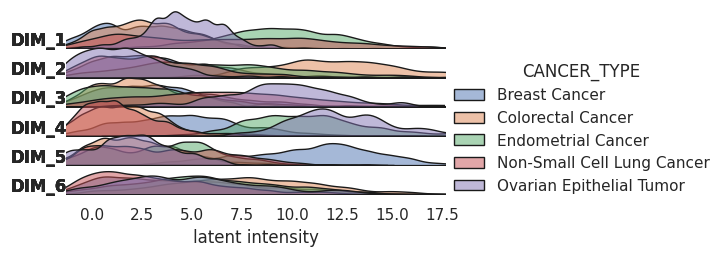

Latent intensity of each dimension grouped by female/male patients


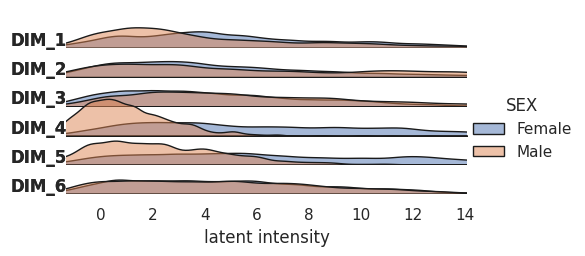

In [17]:
ridge_subtype = Image(filename='reports/TCGA-Example/figures/latent_dist_CANCER_TYPE.png', width=800)

ridge_grade = Image(filename='reports/TCGA-Example/figures/latent_dist_SEX.png', width=800)

print("Latent intensity of each dimension grouped by cancer subtypes")
display(ridge_subtype)
print("Latent intensity of each dimension grouped by female/male patients")
display(ridge_grade)

(3) 2D Latent space representation (via UMAP)  
UMAP is used to reduce from six latent dimensions to two dimensions.

2D latent space colored by cancer subtypes


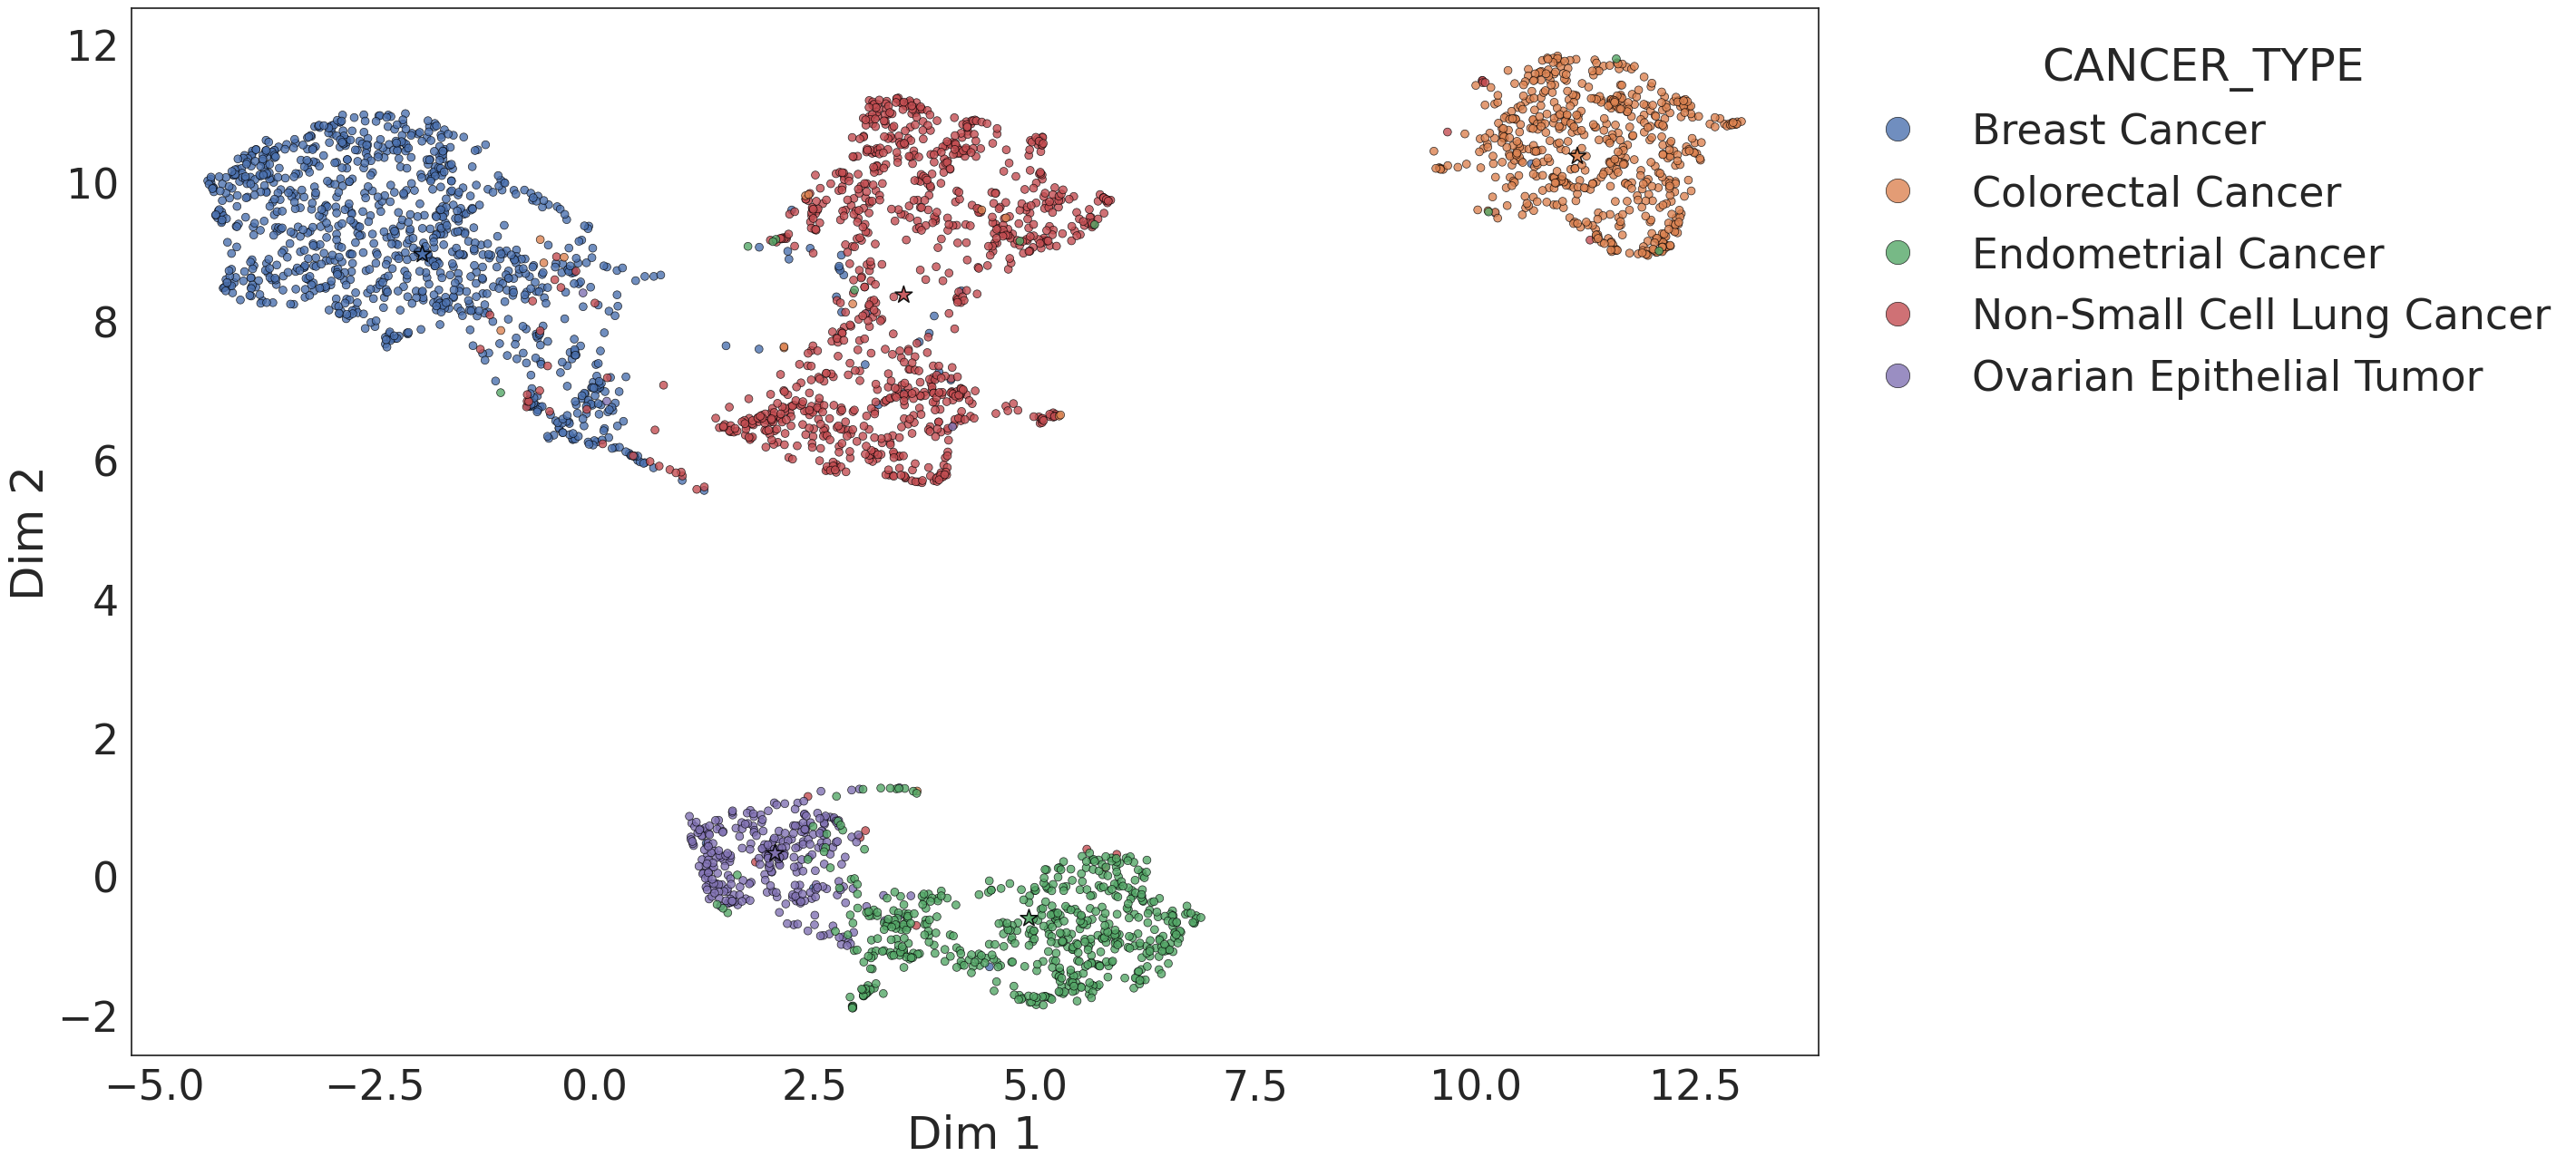

2D latent space colored by female/male patients


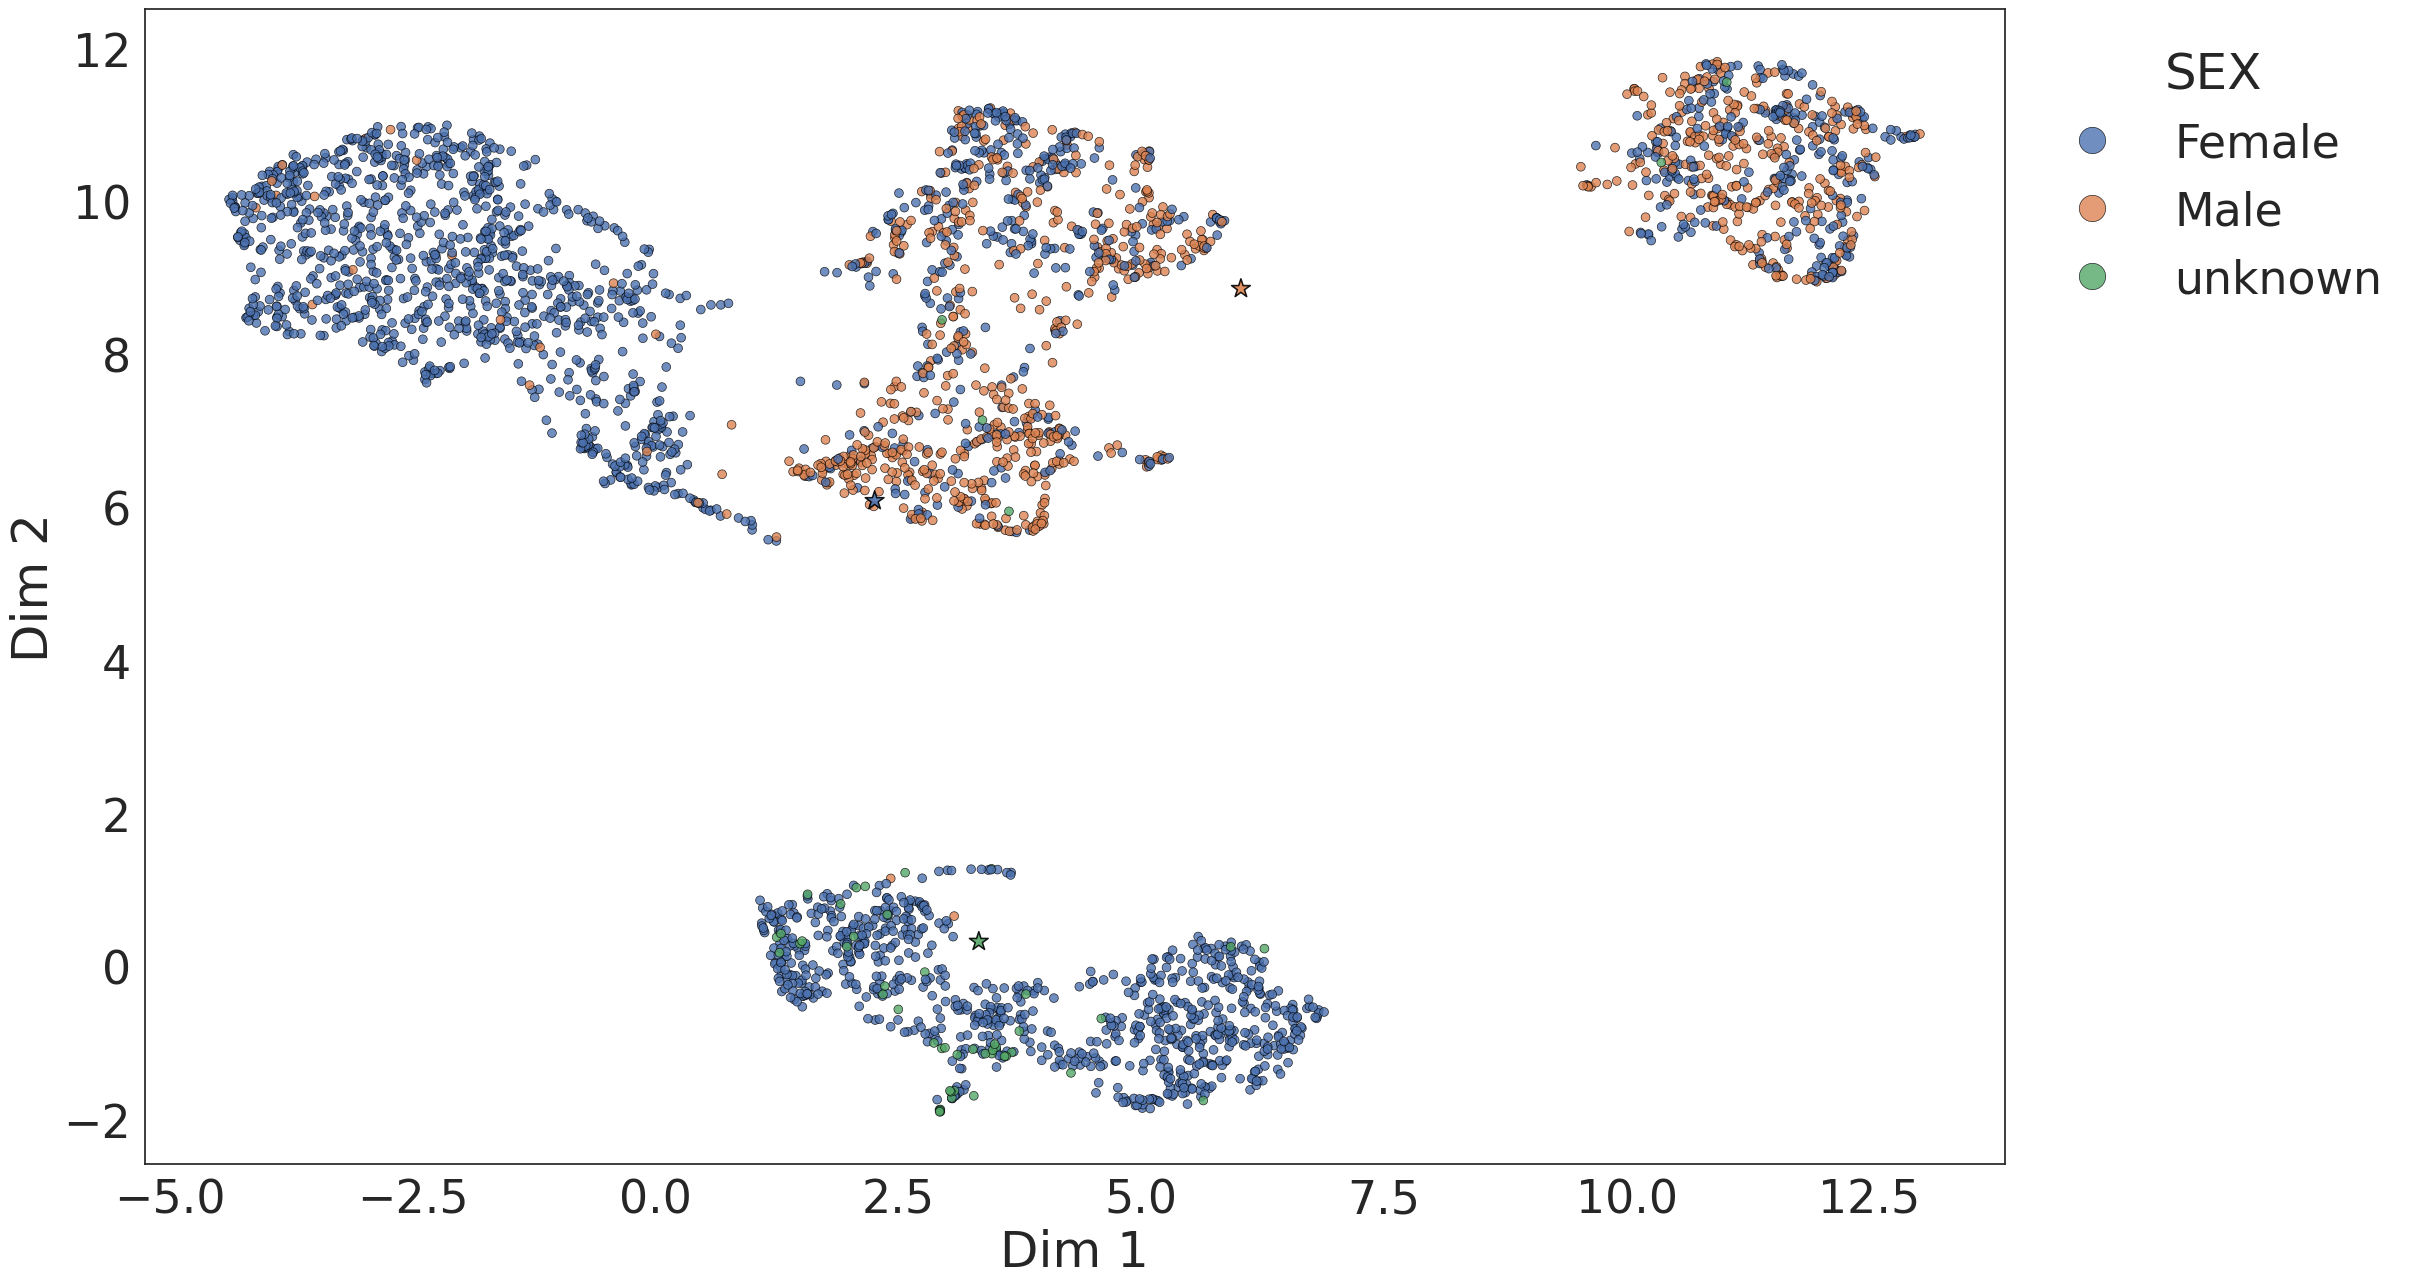

In [18]:
latent2D_subtype = Image(filename='reports/TCGA-Example/figures/latent2D_CANCER_TYPE.png', width=800)
latent2D_grade = Image(filename='reports/TCGA-Example/figures/latent2D_SEX.png', width=800)

print("2D latent space colored by cancer subtypes")
display(latent2D_subtype)
print("2D latent space colored by female/male patients")
display(latent2D_grade)

### (Step 3E) Evaluate embedding performance by machine learnig tasks
For the given clinical parameters in the config, we can test our embeddings in comparison to other methods like PCA, UMAP or random feature picking as baseline  
This may take some time, especially since random feature picking is repeated five times. 

In [20]:
!make ml_task_only RUN_ID=TCGA-Example

Detected platform: Linux
Setting up directories and configuration for RUN_ID: TCGA-Example
✓ Configuration complete
python3 src/visualization/ml_task.py TCGA-Example
2025-09-03 16:43:41,685 - src.utils.utils_basic - INFO - Performing predictive power evaluation
2025-09-03 16:43:41,686 - src.utils.utils_basic - INFO - Perform ML task with feature df: Latent
2025-09-03 16:43:41,728 - src.utils.utils_basic - INFO - Perform ML task for target parameter: CANCER_TYPE
2025-09-03 16:43:42,162 - src.utils.utils_basic - INFO - Perform ML task for target parameter: CANCER_TYPE_ACRONYM
2025-09-03 16:43:42,685 - src.utils.utils_basic - INFO - Perform ML task for target parameter: TMB_NONSYNONYMOUS
2025-09-03 16:43:42,686 - src.utils.utils_basic - WARNING - There are NA values in the annotation file. Samples with missing data will be removed for ML task evaluation.
2025-09-03 16:43:43,144 - src.utils.utils_basic - INFO - Perform ML task for target parameter: AGE
2025-09-03 16:43:43,567 - src.utils.u

Results are stored in a text file `ml_task_performance.txt` and visualized in plots for each clinical parameter

For each parameter latent space of trained varix is compared to embedding by PCA, UMAP or random feature picks on each data split created in `make data`.  


Subtype classification performance


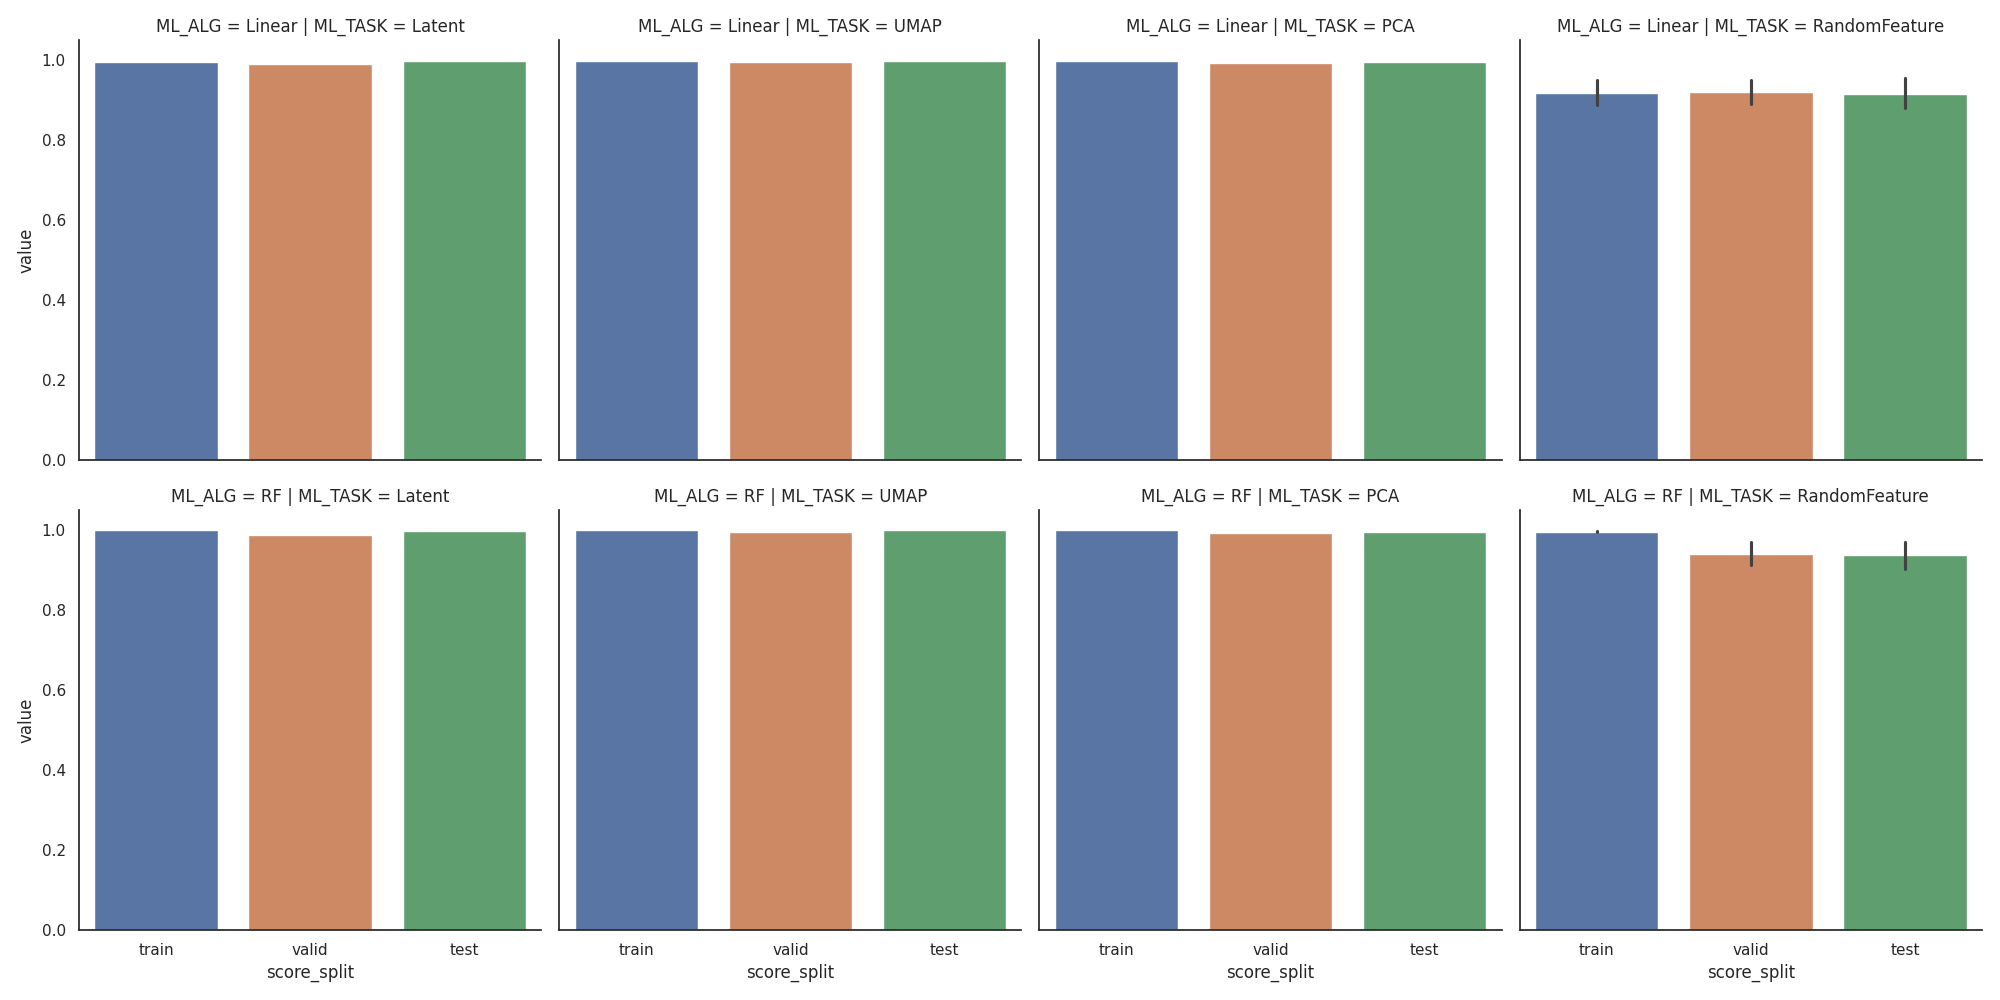

Female/male classification performance


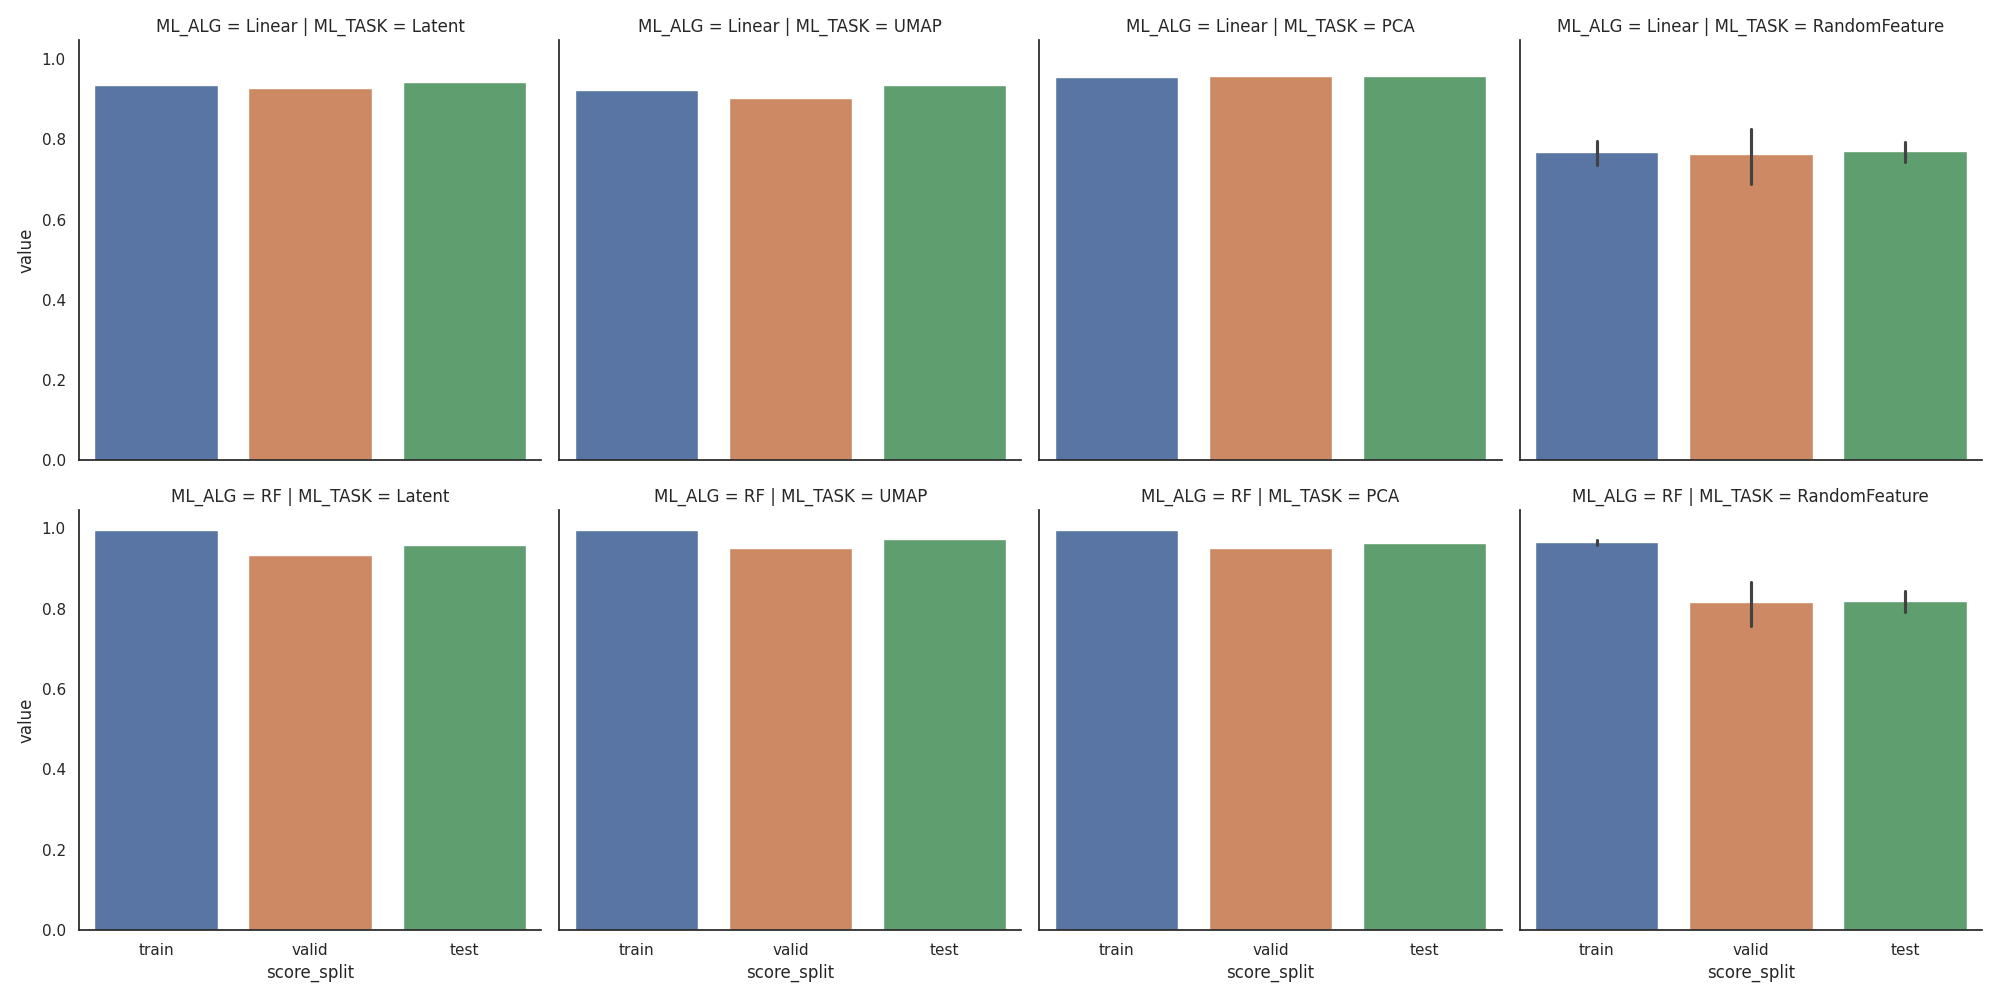

In [21]:
ml_subtype = Image(filename='reports/TCGA-Example/figures/ml_task_performance_CANCER_TYPE_roc_auc_ovo.png', width=800)
ml_fm = Image(filename='reports/TCGA-Example/figures/ml_task_performance_SEX_roc_auc_ovo.png', width=800)


print("Subtype classification performance")
display(ml_subtype)
print("Female/male classification performance")
display(ml_fm)

First row shows performance on linear models (linear regression or logistic regression) and second row on RandomForest as machine learning algorithm.  

We see that cancer type classification is fairly easy and all methods VAE, UMAP and PCA do very well. Female/male classification is slightly harder on the omics data and VAEs are again as performant as other methods. 

Check out the Ontix tutorial to see how biologically-informed VAEs can significantly improve performance for that case. 
